In [2]:
import pandas as pd
import numpy as np
rename_dict = {
    'clientID': 'client',
    'trDte': 'visit_date', 
    'itemGroup': 'item_group'
}

transaction = pd.read_csv('transaction_.csv')
transaction = transaction.rename(columns=rename_dict)
# Преобразование даты (уже с новым именем)
transaction['visit_date'] = pd.to_datetime(transaction['visit_date'], format='%d.%m.%Y')
print(transaction.head(5))

transaction_raw = pd.read_csv('transaction.csv')
print("Исходные колонки:", transaction_raw.columns.tolist())

  visit_date          bcode       client      item  \
0 2017-09-01  code000000001  client13166   sku8444   
1 2017-09-01  code000000001  client13166  sku12545   
2 2017-09-01  code000000001  client13166   sku3391   
3 2017-09-01  code000000001  client13166  sku20444   
4 2017-09-01  code000000002   client1239  sku29959   

                     item_group  quantity  amount  
0              Скобяные изделия         1      29  
1  Оборудование для сада и дачи         1     329  
2                   Инструменты         1     169  
3                   Инструменты         2     578  
4              Скобяные изделия         1     329  
Исходные колонки: ['trDte', 'bcode', 'clientID', 'item', 'itemGroup', 'quantity', 'amount']


In [3]:

print("1. ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ")
print(f"Количество строк: {transaction.shape[0]}")
print(f"Количество столбцов: {transaction.shape[1]}")
print("\nТипы данных:")
print(transaction.dtypes)
print("\nПример первых 5 строк:")
print(transaction.head())

print("\n\n2. ОПИСАТЕЛЬНАЯ СТАТИСТИКА (quantity, amount)")
numeric_cols = ['quantity', 'amount']

# Проверка, существуют ли колонки
missing_cols = [col for col in numeric_cols if col not in transaction.columns]
if missing_cols:
    print(f"Не найдены колонки: {missing_cols}")
    print("Доступные колонки:", transaction.columns.tolist())
else:
    # Приведём к числовому типу на случай, если они object
    transaction['quantity'] = pd.to_numeric(transaction['quantity'], errors='coerce')
    transaction['amount'] = pd.to_numeric(transaction['amount'], errors='coerce')

    # Основные статистики
    stats = transaction[numeric_cols].describe()

    # Добавим медиану (50% уже есть, но назовём явно)
    median = transaction[numeric_cols].median()
    stats.loc['median'] = median

    print(stats.T.round(2))  # Транспонируем и округляем для красоты

1. ОБЩАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ
Количество строк: 1008688
Количество столбцов: 7

Типы данных:
visit_date    datetime64[ns]
bcode                 object
client                object
item                  object
item_group            object
quantity               int64
amount                 int64
dtype: object

Пример первых 5 строк:
  visit_date          bcode       client      item  \
0 2017-09-01  code000000001  client13166   sku8444   
1 2017-09-01  code000000001  client13166  sku12545   
2 2017-09-01  code000000001  client13166   sku3391   
3 2017-09-01  code000000001  client13166  sku20444   
4 2017-09-01  code000000002   client1239  sku29959   

                     item_group  quantity  amount  
0              Скобяные изделия         1      29  
1  Оборудование для сада и дачи         1     329  
2                   Инструменты         1     169  
3                   Инструменты         2     578  
4              Скобяные изделия         1     329  


2. ОПИСАТЕЛЬНАЯ СТАТИСТИКА

In [4]:
def aggregate_client_daily_items(df):
    required_cols = {'client', 'visit_date', 'item', 'item_group', 'quantity', 'amount'}
    missing_cols = required_cols - set(df.columns)
    if missing_cols:
        raise ValueError(f"Не хватает колонок после переименования: {missing_cols}")

    if df['visit_date'].isnull().sum() > 0:
        print(f"⚠️  Удалено {df['visit_date'].isnull().sum()} строк с некорректной датой.")
        df = df.dropna(subset=['visit_date'])

    grouped = (df
               .groupby(['client', 'visit_date', 'item', 'item_group'], as_index=False)
               .agg({'quantity': 'sum', 'amount': 'sum'})
               .rename(columns={'visit_date': 'visit_date'}))

    # Сортировка
    result = grouped.sort_values(by=['client', 'visit_date', 'item']).reset_index(drop=True)
    return result

# print(transaction.head(10))
print(aggregate_client_daily_items(transaction).head(5))
print(f'Кол-во значений в таблице: {len(aggregate_client_daily_items(transaction))}')


     client visit_date      item     item_group  quantity  amount
0   client1 2018-01-22  sku10765  Лаки и краски         1      29
1   client1 2018-01-22  sku13695  Стойматериалы         5    1535
2   client1 2018-01-22  sku29083  Лаки и краски         2     310
3   client1 2018-01-22   sku2954  Лаки и краски         1     399
4  client10 2019-08-05   sku1893    Инструменты         1      79
Кол-во значений в таблице: 1003083


Задача: на дату актуальности (конец периода наблюдения) рассчитать для каждого клиента его профиль с
RFM и дополнительными признаками.

Напиши функцию calculate_client_profile_at_date(visits_df,
observation_end_date).
Функция должна:
1. Фильтровать визиты СТРОГО ДО observation_end_date
(visit_date < observation_end_date)
Это важно для метода аналогий — нет утечки данных!
2. Для каждого клиента рассчитать RFM признаки:
 - Recency: количество дней между последним визитом и
observation_end_date
- Frequency: количество УНИКАЛЬНЫХ ДАТ визитов (не товаров!)
 - Monetary: общая сумма всех покупок
3. Дополнительные признаки:
 - last_visit_date: дата последнего визита
 - total_quantity: общее количество товаров
 - avg_check: средний чек (Monetary / Frequency)
- total_unique_items: количество уникальных товаров за
историю
 - avg_items_per_visit: среднее количество товаров на визит
 - weekend_visits: количество визитов в субботу и воскресенье
 - amount_last_visit: сумма последнего визита
4. Вернуть DataFrame с профилями, отсортированный по client.

In [5]:
def calculate_client_profile_at_date(visits_df, observation_end_date):
    """Профиль клиентов на дату (только визиты до этой даты)."""
    
    obs_date = pd.to_datetime(observation_end_date)
    visits = visits_df.copy()
    visits['visit_date'] = pd.to_datetime(visits['visit_date'], errors='coerce')
    visits = visits.dropna(subset=['visit_date'])
    
    visits = visits[visits['visit_date'] < obs_date]
    if visits.empty:
        return pd.DataFrame()
    
    visits['is_weekend'] = visits['visit_date'].dt.dayofweek >= 5
    
    # Основные агрегации
    agg = visits.groupby('client').agg(
        last_visit=('visit_date', 'max'),
        visits=('visit_date', 'count'),
        unique_visits=('visit_date', 'nunique'),
        amount=('amount', 'sum'),
        quantity=('quantity', 'sum'),
        items=('item', 'nunique'),
        weekends=('is_weekend', 'sum')
    ).reset_index()
    
    # Расчет метрик
    agg['Recency'] = (obs_date - agg['last_visit']).dt.days
    agg['Frequency'] = agg['unique_visits']
    agg['Monetary'] = agg['amount']
    agg['avg_check'] = agg['amount'] / agg['Frequency']
    agg['avg_items'] = agg['quantity'] / agg['Frequency']
    
    # Сумма последнего визита
    last_amount = visits.loc[visits.groupby('client')['visit_date'].idxmax()]
    agg = agg.merge(last_amount[['client', 'amount']].rename(
        columns={'amount': 'last_visit_amount'}), on='client')
    
    return agg.sort_values('client').reset_index(drop=True)

observation_end_date = '2019-09-01'
print(calculate_client_profile_at_date(transaction, observation_end_date).head(10))
print(f"Всего клиентов: {len(calculate_client_profile_at_date(transaction, observation_end_date))}")
client_profile = calculate_client_profile_at_date(transaction, observation_end_date)


        client last_visit  visits  unique_visits  amount  quantity  items  \
0      client1 2018-01-22       4              1    2273         9      4   
1     client10 2019-08-05       3              1    4757         3      3   
2    client100 2019-05-08       1              1    7299         1      1   
3   client1000 2019-08-24      32             12   31792       151     28   
4  client10000 2018-08-01       5              1    8495         5      5   
5  client10001 2019-08-11      18              5    1874        33     18   
6  client10002 2019-05-30      18              4    5850        25     18   
7  client10003 2019-08-31     149             39   54360       577    110   
8  client10004 2019-07-28      38             10    7204        50     35   
9  client10005 2019-05-08      24              5    4846        33     22   

   weekends  Recency  Frequency  Monetary    avg_check  avg_items  \
0         0      587          1      2273  2273.000000   9.000000   
1         0   

In [6]:
def mark_events(visits_df, result_start_date, result_end_date):

    start_date = pd.to_datetime(result_start_date)
    end_date = pd.to_datetime(result_end_date)

    base_clients = visits_df['client'].unique()
    
    period_mask = (visits_df['visit_date'] >= start_date) & (visits_df['visit_date'] < end_date)
    active_clients = visits_df.loc[period_mask, 'client'].unique()
    
    # 3. Создаем DataFrame только для базовых клиентов
    result = pd.DataFrame({
        'client': base_clients,
        'event': [1 if client in active_clients else 0 for client in base_clients]
    })
    
    return result

result_start_date, result_end_date = '2019-09-01', '2019-10-01'

daily_summary = aggregate_client_daily_items(transaction)

daily_summary['visit_date'] = pd.to_datetime(daily_summary['visit_date'])

min_date = daily_summary['visit_date'].min().date()
max_date = daily_summary['visit_date'].max().date()

event_labels = mark_events(daily_summary, result_start_date, result_end_date)
print(f"Количество уникальных клиентов: {len(event_labels)}")
print(f"Количество вернувшихся: {event_labels['event'].sum()}")
print(f"Процент вернувшихся: {event_labels['event'].mean() * 100:.1f}%")
print(f"Клиентов, НЕ посетивших: {(event_labels['event'] == 0).sum()} ({(1 - event_labels['event'].mean()) * 100:.1f}%)")

print("\nРазметка событий (первые 15 строк):")
print(event_labels.head(15).to_string(index=False))



Количество уникальных клиентов: 42746
Количество вернувшихся: 8821
Процент вернувшихся: 20.6%
Клиентов, НЕ посетивших: 33925 (79.4%)

Разметка событий (первые 15 строк):
     client  event
    client1      0
   client10      0
  client100      0
 client1000      1
client10000      0
client10001      0
client10002      0
client10003      1
client10004      1
client10005      0
client10006      0
client10007      0
client10008      0
client10009      0
 client1001      0


In [7]:
def create_train_df(profile_df, events_df):
    # 1. INNER JOIN по client
    df = profile_df.merge(events_df, on='client', how='inner')

    # 2. Проверяем отсутствие пропусков в целевой переменной event
    if df['event'].isna().any():
        raise ValueError("Ошибка: целевая переменная 'event' содержит пропуски!")

    # Приводим event к булевому типу (True/False)
    df['event'] = df['event'].astype(bool)

    # 3. Удаляем служебные колонки с датами
    date_cols = [col for col in df.columns if 'date' in col.lower()]
    df = df.drop(columns=date_cols, errors='ignore')

    # 4. Проверяем наличие обоих классов
    if df['event'].nunique() < 2:
        raise ValueError("В выборке только один класс события (нужно и True, и False)!")
    
    # print(f"Готовая обучающая выборка: {df.shape[0]} строк, {df.shape[1]} признаков")

    # 5. Возвращаем выборку
    return df

profile_df = calculate_client_profile_at_date(transaction, observation_end_date)
events_df = mark_events(transaction, result_start_date, result_end_date)

train_df = create_train_df(profile_df, events_df)

print(f"Готовая обучающая выборка: {train_df.shape[0]} строк, {train_df.shape[1]} признаков")
train_df = train_df.loc[:, ~train_df.columns.duplicated()]
print(f"После удаления дубликатов в train_df:")
print(f"Колонки: {train_df.columns.tolist()}")
# ========================================================
print("\nРаспределение классов:\n", train_df['event'].value_counts())
print("\nДоля классов (%):\n", train_df['event'].value_counts(normalize=True) * 100)
print("\nПризнаки выборки:\n", list(train_df.columns))

print("\nПример обучающей выборки (первые 10 строк):")
print("=" * 80)

print(train_df.head(10).to_string(index=False))


Готовая обучающая выборка: 39906 строк, 15 признаков
После удаления дубликатов в train_df:
Колонки: ['client', 'last_visit', 'visits', 'unique_visits', 'amount', 'quantity', 'items', 'weekends', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'avg_items', 'last_visit_amount', 'event']

Распределение классов:
 event
False    32375
True      7531
Name: count, dtype: int64

Доля классов (%):
 event
False    81.128151
True     18.871849
Name: proportion, dtype: float64

Признаки выборки:
 ['client', 'last_visit', 'visits', 'unique_visits', 'amount', 'quantity', 'items', 'weekends', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'avg_items', 'last_visit_amount', 'event']

Пример обучающей выборки (первые 10 строк):
     client last_visit  visits  unique_visits  amount  quantity  items  weekends  Recency  Frequency  Monetary   avg_check  avg_items  last_visit_amount  event
    client1 2018-01-22       4              1    2273         9      4         0      587          1      2273 2273.0

In [8]:
profile2 = calculate_client_profile_at_date(
    daily_summary, #aggregate_client_daily_items
    observation_end_date='2019-10-01')

print("Профиль на 2019-10-01 построен")
print(f"Клиентов: {len(profile2)}")

events2 = mark_events(daily_summary, result_start_date='2019-10-01', result_end_date='2019-11-01')

print(f"Всего клиентов: {len(events2)}")
print(f"Вернулись в октябре: {events2['event'].sum()}")


test_data = create_train_df(profile2, events2)

print("Тестовая выборка создана")
print(f"Размер: {test_data.shape[0]} клиентов, {test_data.shape[1]} признаков")

test_data = test_data.loc[:, ~test_data.columns.duplicated()]
print(f"После удаления дубликатов в test_data:")
print(f"Колонки: {test_data.columns.tolist()}")
# =============================================================

test_data = test_data.copy()  # Чтобы не было предупреждений

# Добавим метку периода и типа данных
test_data['_sample_date'] = '2019-10-01'
test_data['_target_period'] = '2019-10'
test_data['_dataset_type'] = 'test'

event_counts = test_data['event'].value_counts()
if True in event_counts:
    print(f"event = True:  {event_counts[True]} ({100 * event_counts[True] / len(test_data):.1f}%)")
if False in event_counts:
    print(f"event = False: {event_counts[False]} ({100 * event_counts[False] / len(test_data):.1f}%)")

print("\nПример данных (первые 8 строк):")
print(test_data.head(8)[['client', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'event', '_target_period']].to_string(index=False))
rain_df = train_df.loc[:, ~train_df.columns.duplicated()]
test_data = test_data.loc[:, ~test_data.columns.duplicated()]

print(f"После удаления дубликатов:")
print(f"train_df колонки: {train_df.columns.tolist()}")
print(f"test_data колонки: {test_data.columns.tolist()}")

profile2.to_csv('results/profile2_.csv', index=False, encoding='utf-8-sig')
events2.to_csv('results/events2_.csv', index=False, encoding='utf-8-sig')
test_data.to_csv('results/test_data.csv', index=False, encoding='utf-8-sig')
train_df.to_csv('results/train_data.csv', index=False, encoding='utf-8-sig')

print("Все датасеты сохранены")

check_train = pd.read_csv('results/train_data.csv')
check_test = pd.read_csv('results/test_data.csv')
print("\nФайлы успешно проверены: можно прочитать обратно.")
print(f"Обучающая: {check_train.shape}")
print(f"Тестовая: {check_test.shape}")


Профиль на 2019-10-01 построен
Клиентов: 41196
Всего клиентов: 42746
Вернулись в октябре: 9324
Тестовая выборка создана
Размер: 41196 клиентов, 15 признаков
После удаления дубликатов в test_data:
Колонки: ['client', 'last_visit', 'visits', 'unique_visits', 'amount', 'quantity', 'items', 'weekends', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'avg_items', 'last_visit_amount', 'event']
event = True:  7774 (18.9%)
event = False: 33422 (81.1%)

Пример данных (первые 8 строк):
     client  Recency  Frequency  Monetary   avg_check  event _target_period
    client1      617          1      2273 2273.000000  False        2019-10
   client10       57          1      4757 4757.000000  False        2019-10
  client100      146          1      7299 7299.000000   True        2019-10
 client1000       17         13     36495 2807.307692   True        2019-10
client10000      426          1      8495 8495.000000  False        2019-10
client10001       51          5      1874  374.800000  False  

Загрузка данных...
Успешно
Обучающая выборка: (39906, 15)
Тестовая выборка:  (41196, 18)

🧮 Обучение BinningProcess...
BinningProcess обучен

NFORMATION VALUE (IV) — отсортировано по убыванию
         Variable       IV
          Recency 1.182696
    unique_visits 0.838749
        Frequency 0.838749
           visits 0.634528
            items 0.612131
         quantity 0.588133
           amount 0.481972
         Monetary 0.481972
         weekends 0.436189
        avg_items 0.170903
        avg_check 0.053070
last_visit_amount 0.020511

ИНТЕРПРЕТАЦИЯ ПО IV:
  Recency                   | IV=1.183 | 🔥 Очень сильный
  unique_visits             | IV=0.839 | 🔥 Очень сильный
  Frequency                 | IV=0.839 | 🔥 Очень сильный
  visits                    | IV=0.635 | 🔥 Очень сильный
  items                     | IV=0.612 | 🔥 Очень сильный
  quantity                  | IV=0.588 | 🔥 Очень сильный
  amount                    | IV=0.482 | 🟠 Сильный
  Monetary                  | IV=0.482 | 🟠

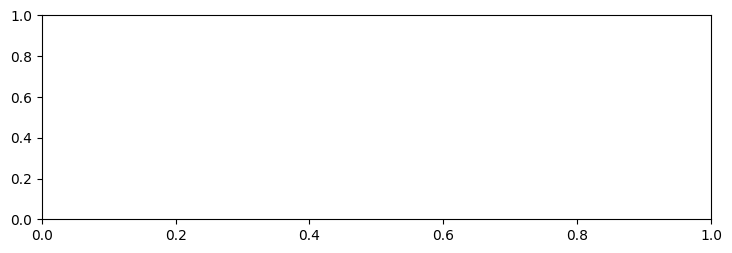

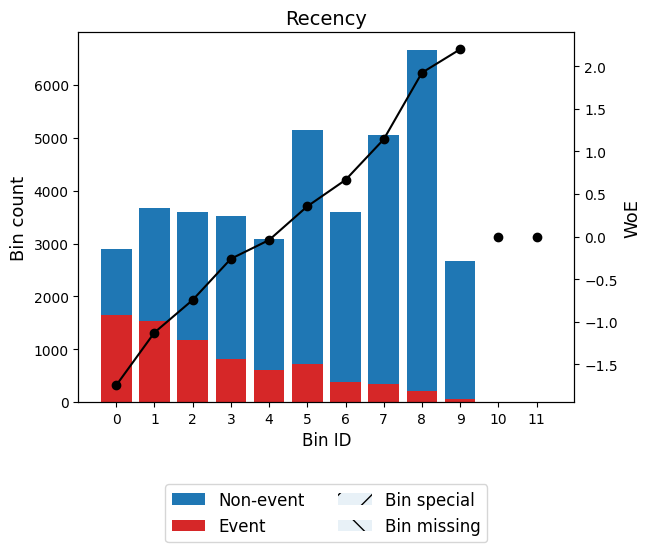

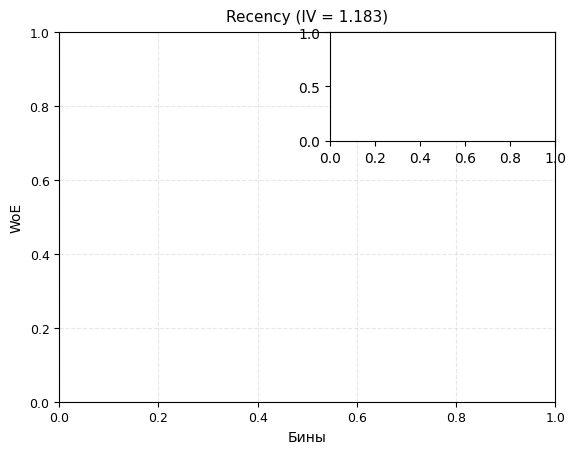

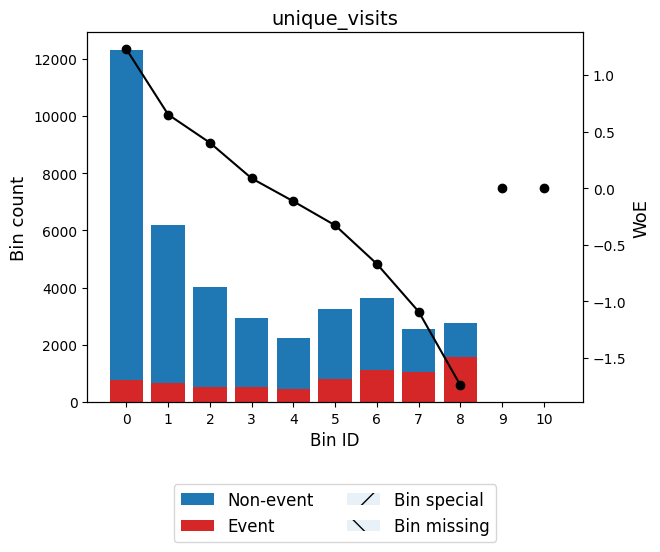

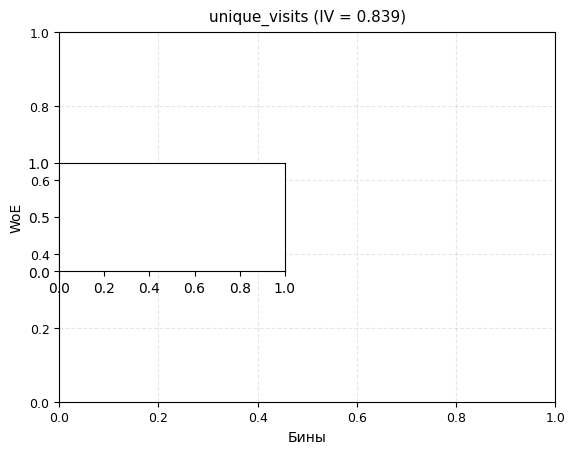

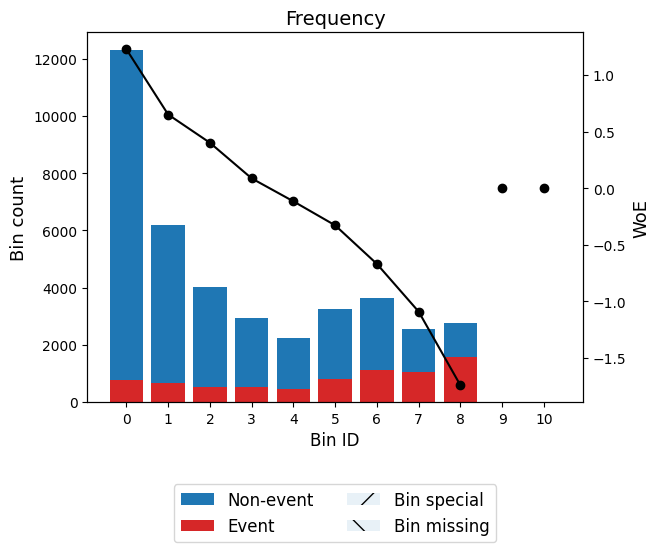

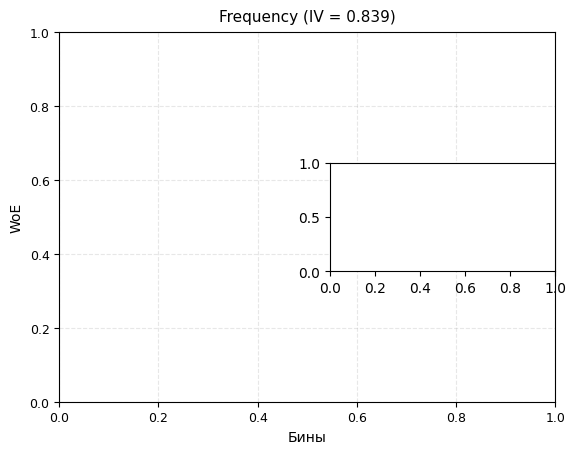

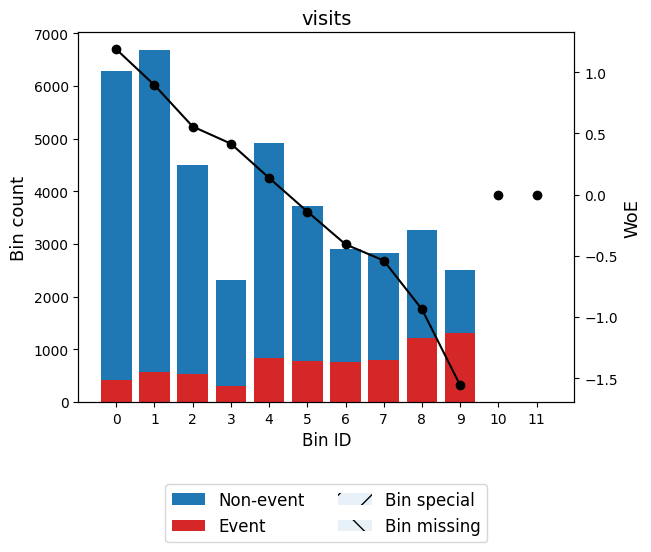

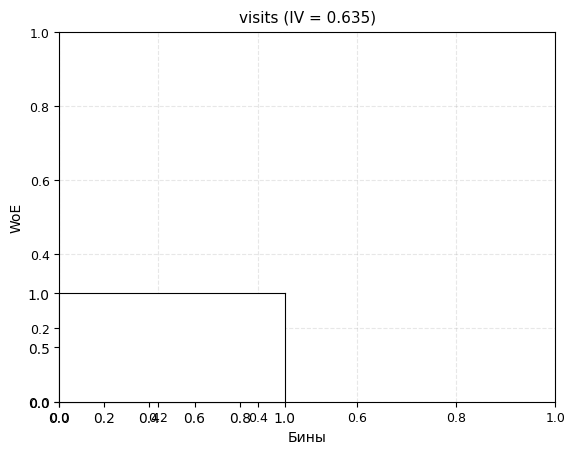

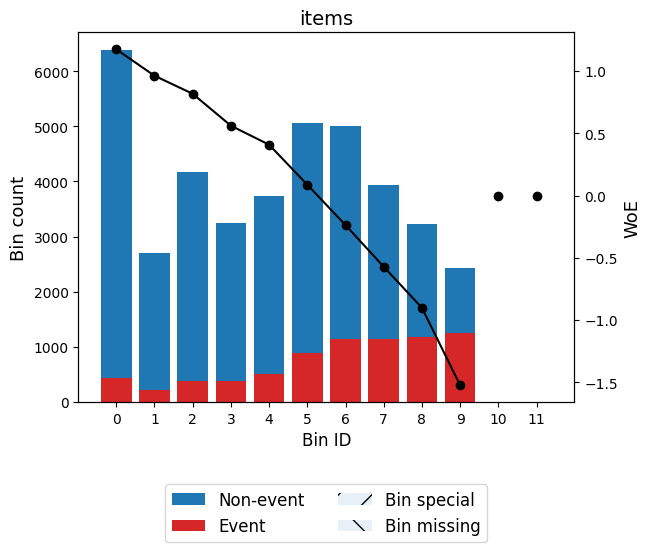

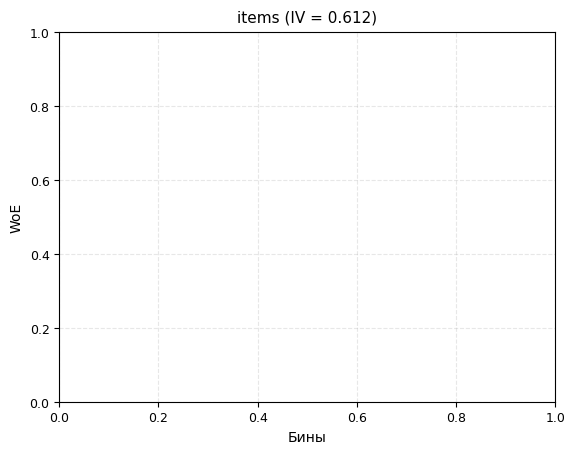


Преобразование X_train и X_test в WoE...
X_train_woe: (39906, 12), X_test_woe: (41196, 12)
Готово!
   • train_woe.csv
   • test_woe.csv
BinningProcess сохранён в 'binning_process_test.pkl'

Загрузка данных из results/test_data.csv...
Колонки в данных: ['client', 'last_visit', 'visits', 'unique_visits', 'amount', 'quantity', 'items', 'weekends', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'avg_items', 'last_visit_amount', 'event', '_sample_date', '_target_period', '_dataset_type']

Числовые признаки: ['visits', 'unique_visits', 'amount', 'quantity', 'items', 'weekends', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'avg_items', 'last_visit_amount']
Кол-во признаков: 12

Признаки в binning_process: ['visits', 'unique_visits', 'amount', 'quantity', 'items', 'weekends', 'Recency', 'Frequency', 'Monetary', 'avg_check', 'avg_items', 'last_visit_amount']

X_new_woe преобразован: (41196, 12)
Преобразованные данные сохранены в 'results/X_new_woe_test.csv'


In [9]:
import os
import matplotlib.pyplot as plt
from optbinning import BinningProcess
import pickle


train_path = 'results/train_data.csv'
test_path = 'results/test_data.csv'

print("Загрузка данных...")
try:
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    print(f"Успешно")
    print(f"Обучающая выборка: {train_data.shape}")
    print(f"Тестовая выборка:  {test_data.shape}")
except FileNotFoundError as e:
    raise FileNotFoundError(f"Файл не найден. Проверьте путь:\n{e}")

if 'event' not in train_data.columns or 'event' not in test_data.columns:
    raise ValueError("В данных отсутствует колонка 'event'")

X_train = train_data.drop(columns=['clientID', 'event'], errors='ignore')
y_train = train_data['event']

X_test = test_data.drop(columns=['clientID', 'event'], errors='ignore')
y_test = test_data['event']

X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Синхронизация колонок
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

numerical_features = X_train.columns.tolist()
# print(f"Признаки: {len(numerical_features)} числовых")

print("\n🧮 Обучение BinningProcess...")
binning_process = BinningProcess(
    variable_names=numerical_features,
    min_n_bins=3,
    max_n_bins=10,
    min_bin_size=0.05
)

binning_process.fit(X_train, y_train)
print("BinningProcess обучен")

print("\nNFORMATION VALUE (IV) — отсортировано по убыванию")
print("=" * 70)

iv_data = []
for var in numerical_features:
    # Получаем биннер
    optb = binning_process.get_binned_variable(var)
    # Строим таблицу — это гарантирует вычисление IV
    table = optb.binning_table.build()
    # Теперь можно получить IV
    iv = optb.binning_table.iv
    iv_data.append({'Variable': var, 'IV': iv})

iv_summary = pd.DataFrame(iv_data).sort_values(by='IV', ascending=False).reset_index(drop=True)
print(iv_summary.to_string(index=False))

# Интерпретация IV
def interpret_iv(iv):
    if iv < 0.02: return "❌ Очень слабый"
    elif iv < 0.1: return "🟡 Слабый"
    elif iv < 0.3: return "🟢 Умеренный"
    elif iv < 0.5: return "🟠 Сильный"
    else: return "🔥 Очень сильный"

iv_summary['Интерпретация'] = iv_summary['IV'].apply(interpret_iv)
print("\nИНТЕРПРЕТАЦИЯ ПО IV:")
for _, row in iv_summary.iterrows():
    print(f"  {row['Variable']:25} | IV={row['IV']:.3f} | {row['Интерпретация']}")


top5_vars = iv_summary['Variable'].head(5)
print(f"\nТАБЛИЦЫ WoE ДЛЯ ТОП-5 ПРИЗНАКОВ")
print("=" * 90)
for var in top5_vars:
    optb = binning_process.get_binned_variable(var)
    woe_table = optb.binning_table.build()  # Строим явно
    print(f"\n🔹 {var.upper()} (IV = {optb.binning_table.iv:.3f})")
    print(woe_table[['Bin', 'Count', 'Count (%)', 'Non-event', 'Event', 'WoE']])

print("\nРисуем диаграммы WoE для топ-5 признаков...")
# Увеличиваем размер фигуры для лучшей читаемости
plt.figure(figsize=(19, 9))

for i, var in enumerate(top5_vars):
    plt.subplot(3, 2, i + 1)  # Изменено на 2x3 сетку
    
    # Получаем BinningTable (не вызываем .build() как DataFrame!)
    optb = binning_process.get_binned_variable(var)
    binning_table = optb.binning_table  # ← это объект BinningTable
    
    # Строим таблицу (не сохраняем как переменную!)
    binning_table.build()  # ← теперь внутри есть данные
    
    # Рисуем график — он сам использует matplotlib
    binning_table.plot()   # ← рисует WoE

    # Получаем текущие оси и добавляем заголовок
    ax = plt.gca()
    ax.set_title(f"{var} (IV = {binning_table.iv:.3f})", fontsize=11, pad=8)
    ax.set_xlabel("Бины", fontsize=10)
    ax.set_ylabel("WoE", fontsize=10)
    
    # Уменьшаем размер шрифта меток на осях
    ax.tick_params(axis='both', which='major', labelsize=9)
    
    # Делаем легкую сетку для лучшей читаемости
    ax.grid(True, alpha=0.3, linestyle='--')

# Настраиваем компоновку для лучшего использования пространства
# plt.tight_layout(pad=2.0, h_pad=2.5, w_pad=2.5)
plt.show()

print("\nПреобразование X_train и X_test в WoE...")
X_train_woe = binning_process.transform(X_train, metric="woe")
X_test_woe = binning_process.transform(X_test, metric="woe")
print(f"X_train_woe: {X_train_woe.shape}, X_test_woe: {X_test_woe.shape}")

output_dir = 'results'
train_woe = pd.concat([
    train_data[['client', 'event']].reset_index(drop=True),
    pd.DataFrame(X_train_woe, columns=numerical_features)
], axis=1)

test_woe = pd.concat([
    test_data[['client', 'event']].reset_index(drop=True),
    pd.DataFrame(X_test_woe, columns=numerical_features)
], axis=1)

train_woe.to_csv(os.path.join(output_dir, 'train_woe.csv'), index=False, encoding='utf-8-sig')
test_woe.to_csv(os.path.join(output_dir, 'test_woe.csv'), index=False, encoding='utf-8-sig')

print("Готово!")
print("   • train_woe.csv")
print("   • test_woe.csv")

# 1. Сохранение binning_process
with open("binning_process_test.pkl", "wb") as f:
    pickle.dump(binning_process, f)
print("BinningProcess сохранён в 'binning_process_test.pkl'")

# 2. Загрузка binning_process
with open("binning_process_test.pkl", "rb") as f:
    binning_process_loaded = pickle.load(f)

# 3. Загрузка ИСХОДНЫХ данных (не WoE) для трансформации
# Используйте тестовые данные или другие исходные данные
X_new_path = 'results/test_data.csv'  # или 'results/train_data.csv'
print(f"\nЗагрузка данных из {X_new_path}...")
X_new_df = pd.read_csv(X_new_path)

print(f"Колонки в данных: {X_new_df.columns.tolist()}")

# 4. Подготовка X_new так же, как при обучении
X_new = X_new_df.drop(columns=['clientID', 'event'], errors='ignore')
X_new = X_new.select_dtypes(include=[np.number])

print(f"\nЧисловые признаки: {X_new.columns.tolist()}")
print(f"Кол-во признаков: {len(X_new.columns)}")

# 5. Синхронизация с binning_process
# Получаем список признаков из binning_process
required_features = binning_process_loaded.variable_names
print(f"\nПризнаки в binning_process: {required_features}")

# Создаем DataFrame с нужными колонками
X_new_aligned = pd.DataFrame()

for feature in required_features:
    if feature in X_new.columns:
        X_new_aligned[feature] = X_new[feature]
    else:
        print(f"Признак '{feature}' отсутствует. Заполняем нулями.")
        X_new_aligned[feature] = 0


# 6. Преобразуем в WoE
X_new_woe = binning_process_loaded.transform(X_new_aligned, metric="woe")

print(f"\nX_new_woe преобразован: {X_new_woe.shape}")

# 7. Сохраняем результат
X_new_woe_df = pd.DataFrame(X_new_woe, columns=required_features)
X_new_woe_df.to_csv("results/X_new_woe_test.csv", index=False, encoding='utf-8-sig')
print("Преобразованные данные сохранены в 'results/X_new_woe_test.csv'")


ЭТАП 1: КОРРЕЛЯЦИОННЫЙ АНАЛИЗ WoE-ПРИЗНАКОВ


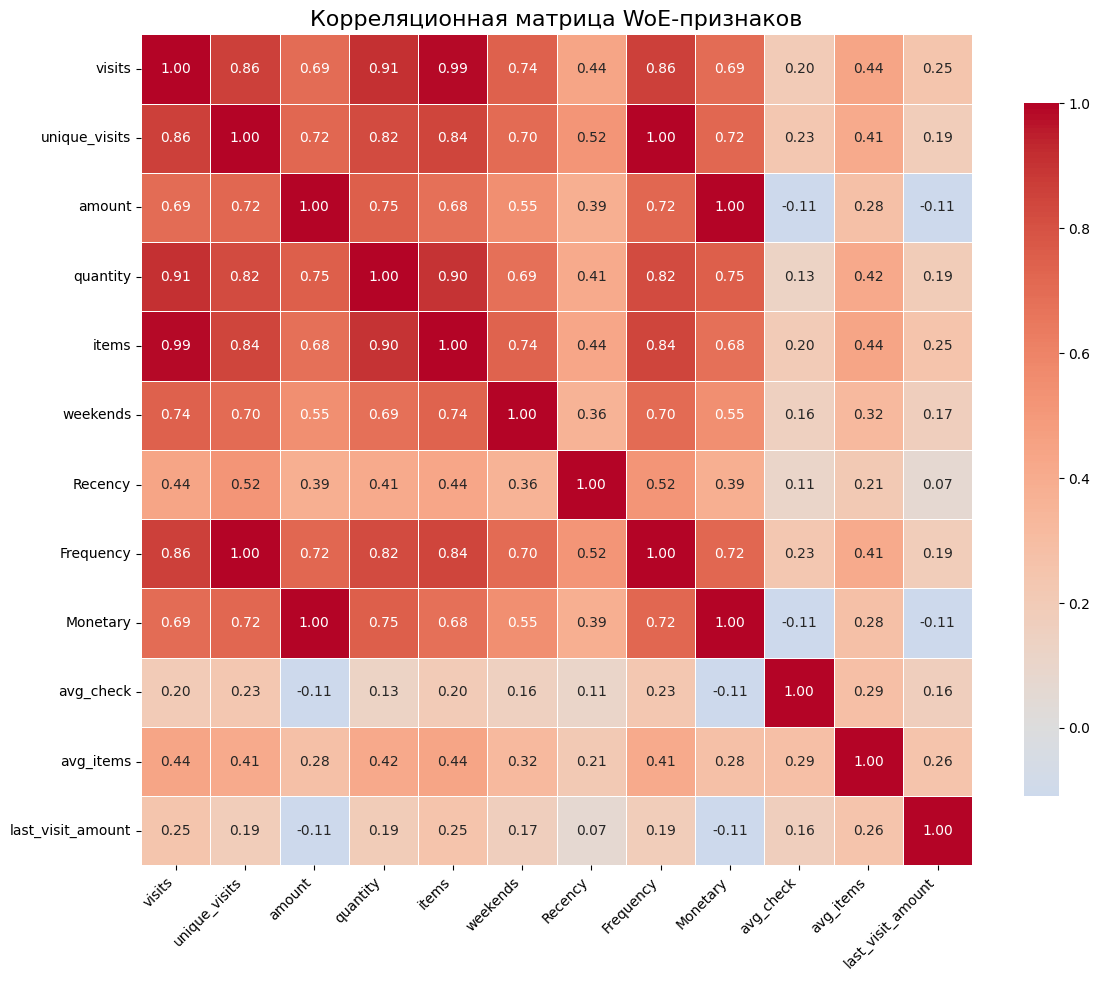


Поиск сильно коррелированных пар (корреляция > 0.7):

Найдено 21 пар с высокой корреляцией:

unique_visits ↔ Frequency: корреляция = 1.000
  IV(unique_visits) = 0.839, IV(Frequency) = 0.839
  → Оставить 'unique_visits' (IV=0.839), удалить 'Frequency'

amount ↔ Monetary: корреляция = 1.000
  IV(amount) = 0.482, IV(Monetary) = 0.482
  → Оставить 'amount' (IV=0.482), удалить 'Monetary'

visits ↔ items: корреляция = 0.990
  IV(visits) = 0.635, IV(items) = 0.612
  → Оставить 'visits' (IV=0.635), удалить 'items'

visits ↔ quantity: корреляция = 0.912
  IV(visits) = 0.635, IV(quantity) = 0.588
  → Оставить 'visits' (IV=0.635), удалить 'quantity'

quantity ↔ items: корреляция = 0.903
  IV(quantity) = 0.588, IV(items) = 0.612
  → Оставить 'items' (IV=0.612), удалить 'quantity'

visits ↔ unique_visits: корреляция = 0.860
  IV(visits) = 0.635, IV(unique_visits) = 0.839
  → Оставить 'unique_visits' (IV=0.839), удалить 'visits'

visits ↔ Frequency: корреляция = 0.860
  IV(visits) = 0.635, IV(Frequ

In [35]:
import seaborn as sns
print("=" * 80)
print("ЭТАП 1: КОРРЕЛЯЦИОННЫЙ АНАЛИЗ WoE-ПРИЗНАКОВ")
print("=" * 80)

# 1. Преобразуем WoE-признаки в DataFrame
X_woe_df = pd.DataFrame(X_train_woe, columns=numerical_features)

# 2. Рассчитываем корреляционную матрицу
correlation_matrix = X_woe_df.corr()

# 3. Визуализация тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            center=0, 
            square=True, 
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title("Корреляционная матрица WoE-признаков", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Находим сильно коррелированные пары (порог = 0.7)
THRESHOLD = 0.7
strong_correlations = []

print(f"\nПоиск сильно коррелированных пар (корреляция > {THRESHOLD}):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = abs(correlation_matrix.iloc[i, j])
        if corr_value > THRESHOLD:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            strong_correlations.append((var1, var2, correlation_matrix.iloc[i, j]))

# 5. Выводим результаты
if strong_correlations:
    print(f"\nНайдено {len(strong_correlations)} пар с высокой корреляцией:")
    
    # Сортируем по убыванию корреляции
    strong_correlations.sort(key=lambda x: abs(x[2]), reverse=True)
    
    for var1, var2, corr in strong_correlations:
        # Находим IV для каждого признака
        iv1 = iv_summary.loc[iv_summary['Variable'] == var1, 'IV'].values
        iv2 = iv_summary.loc[iv_summary['Variable'] == var2, 'IV'].values
        
        iv1 = iv1[0] if len(iv1) > 0 else 0
        iv2 = iv2[0] if len(iv2) > 0 else 0
        
        # Определяем какой признак оставить (с большим IV)
        if iv1 >= iv2:
            keep, drop = var1, var2
            keep_iv, drop_iv = iv1, iv2
        else:
            keep, drop = var2, var1
            keep_iv, drop_iv = iv2, iv1
        
        print(f"\n{var1} ↔ {var2}: корреляция = {corr:.3f}")
        print(f"  IV({var1}) = {iv1:.3f}, IV({var2}) = {iv2:.3f}")
        print(f"  → Оставить '{keep}' (IV={keep_iv:.3f}), удалить '{drop}'")
    
    # 6. Создаем список признаков для удаления
    features_to_drop = []
    for var1, var2, corr in strong_correlations:
        iv1 = iv_summary.loc[iv_summary['Variable'] == var1, 'IV'].values
        iv2 = iv_summary.loc[iv_summary['Variable'] == var2, 'IV'].values
        
        iv1 = iv1[0] if len(iv1) > 0 else 0
        iv2 = iv2[0] if len(iv2) > 0 else 0
        
        if iv1 >= iv2:
            features_to_drop.append(var2)
        else:
            features_to_drop.append(var1)
    
    # Убираем дубликаты
    features_to_drop = list(set(features_to_drop))
    
    print(f"\nИТОГ:")
    print(f"Признаков для удаления: {len(features_to_drop)}")
    print(f"Список: {features_to_drop}")
    
    # 7. Удаляем признаки с меньшим IV
    drop_indices = [i for i, feat in enumerate(numerical_features) if feat in features_to_drop]
    
    # Создаем отфильтрованные наборы данных
    X_train_filtered = np.delete(X_train_woe, drop_indices, axis=1)
    X_test_filtered = np.delete(X_test_woe, drop_indices, axis=1)
    
    # Обновляем список признаков
    numerical_features_filtered = [feat for feat in numerical_features if feat not in features_to_drop]
    
    print(f"\nПосле удаления коррелированных признаков:")
    print(f"Осталось признаков: {len(numerical_features_filtered)}")
    print(f"Список: {numerical_features_filtered}")
    
else:
    print("Сильно коррелированных пар не обнаружено.")
    # Используем все признаки
    X_train_filtered = X_train_woe.copy()
    X_test_filtered = X_test_woe.copy()
    numerical_features_filtered = numerical_features.copy()

X_train_models = X_train.copy()
X_test_models = X_test.copy()
y_train_models = y_train.copy()
y_test_models = y_test.copy()

print("\n" + "=" * 80)
print("✅ ЭТАП 1 ЗАВЕРШЕН")
print("=" * 80)


ЭТАП 2: ЛОГРЕГРЕССИЯ ТОЛЬКО НА RECENCY
ROC-AUC (только Recency): 0.7842

Коэффициент модели:
Recency: -0.0081
Intercept: -0.4664


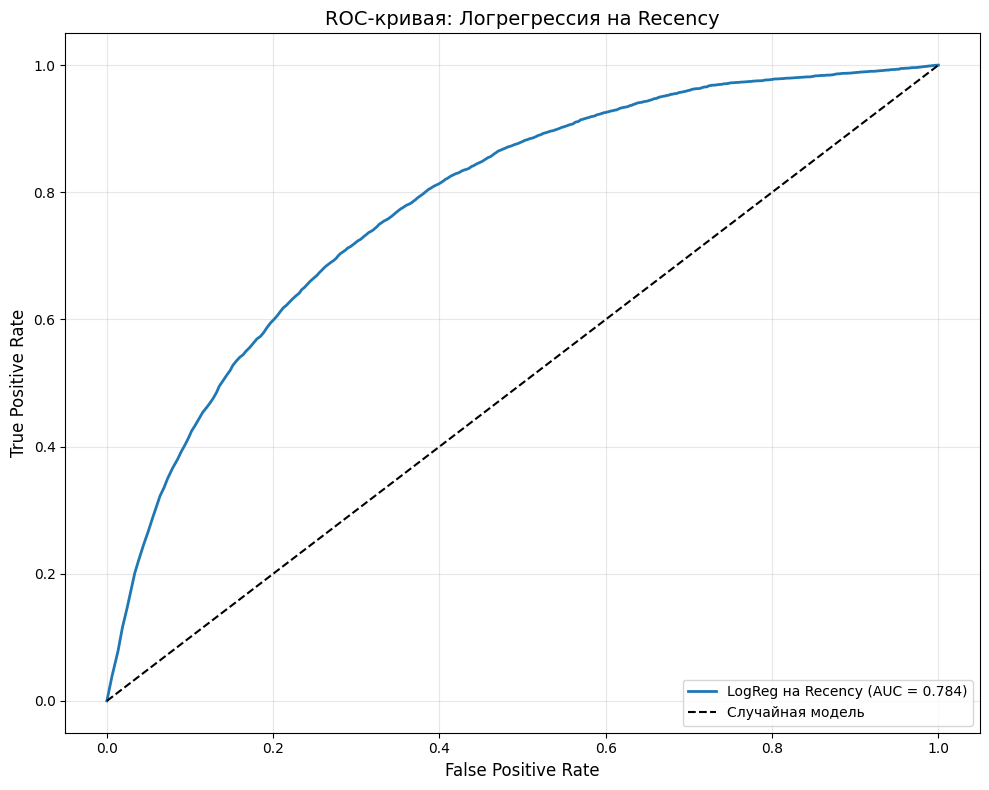


МАТРИЦА ОШИБОК:


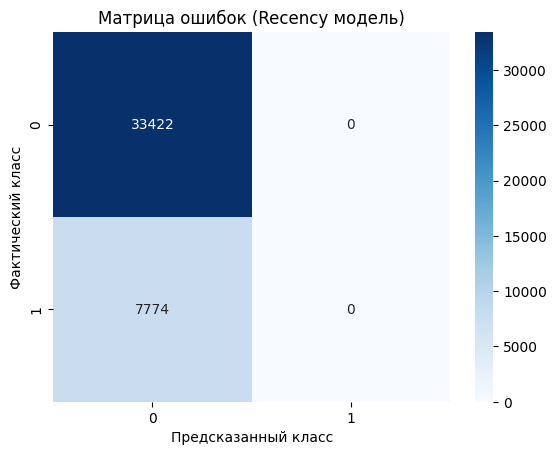


ОТЧЕТ ПО КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

 Не вернутся       0.81      1.00      0.90     33422
    Вернутся       0.00      0.00      0.00      7774

    accuracy                           0.81     41196
   macro avg       0.41      0.50      0.45     41196
weighted avg       0.66      0.81      0.73     41196



C:\Users\Ksenia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ksenia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ksenia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

In [36]:
print("\n" + "=" * 70)
print("ЭТАП 2: ЛОГРЕГРЕССИЯ ТОЛЬКО НА RECENCY")
print("=" * 70)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import seaborn as sns

# 1. Берем только признак Recency
X_train_recency = X_train_models[['Recency']].copy()
X_test_recency = X_test_models[['Recency']].copy()

# 2. Создаем и обучаем модель
model_recency = LogisticRegression(random_state=42)
model_recency.fit(X_train_recency, y_train_models)

# 3. Предсказания
y_pred_prob_recency = model_recency.predict_proba(X_test_recency)[:, 1]
y_pred_recency = model_recency.predict(X_test_recency)

# 4. Оценка модели
roc_auc_recency = roc_auc_score(y_test_models, y_pred_prob_recency)
print(f"ROC-AUC (только Recency): {roc_auc_recency:.4f}")

# 5. Выводим коэффициенты
print(f"\nКоэффициент модели:")
print(f"Recency: {model_recency.coef_[0][0]:.4f}")
print(f"Intercept: {model_recency.intercept_[0]:.4f}")

# 6. ROC-кривая
fpr_recency, tpr_recency, _ = roc_curve(y_test_models, y_pred_prob_recency)

plt.figure(figsize=(10, 8))
plt.plot(fpr_recency, tpr_recency, label=f'LogReg на Recency (AUC = {roc_auc_recency:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривая: Логрегрессия на Recency', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Матрица ошибок
print("\nМАТРИЦА ОШИБОК:")
cm_recency = confusion_matrix(y_test_models, y_pred_recency)
sns.heatmap(cm_recency, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок (Recency модель)')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()

# 8. Отчет по классификации
print("\nОТЧЕТ ПО КЛАССИФИКАЦИИ:")
print(classification_report(y_test_models, y_pred_recency, 
                           target_names=['Не вернутся', 'Вернутся']))


ЭТАП 3: ПОЛНАЯ ЛОГРЕГРЕССИЯ (L2 РЕГУЛЯРИЗАЦИЯ)


C:\Users\Ksenia\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC (полная модель): 0.7981

Улучшение по сравнению с Recency: +1.8%

ВАЖНОСТЬ ПРИЗНАКОВ (абсолютные значения коэффициентов):
          Признак  Коэффициент
            items 5.571301e-02
           visits 5.096904e-02
    unique_visits 2.860869e-02
        Frequency 2.860869e-02
         weekends 8.982421e-03
          Recency 7.259824e-03
        avg_items 5.938603e-03
         quantity 2.597774e-03
        avg_check 1.808411e-05
last_visit_amount 1.067731e-05
           amount 1.074521e-07
         Monetary 1.074521e-07


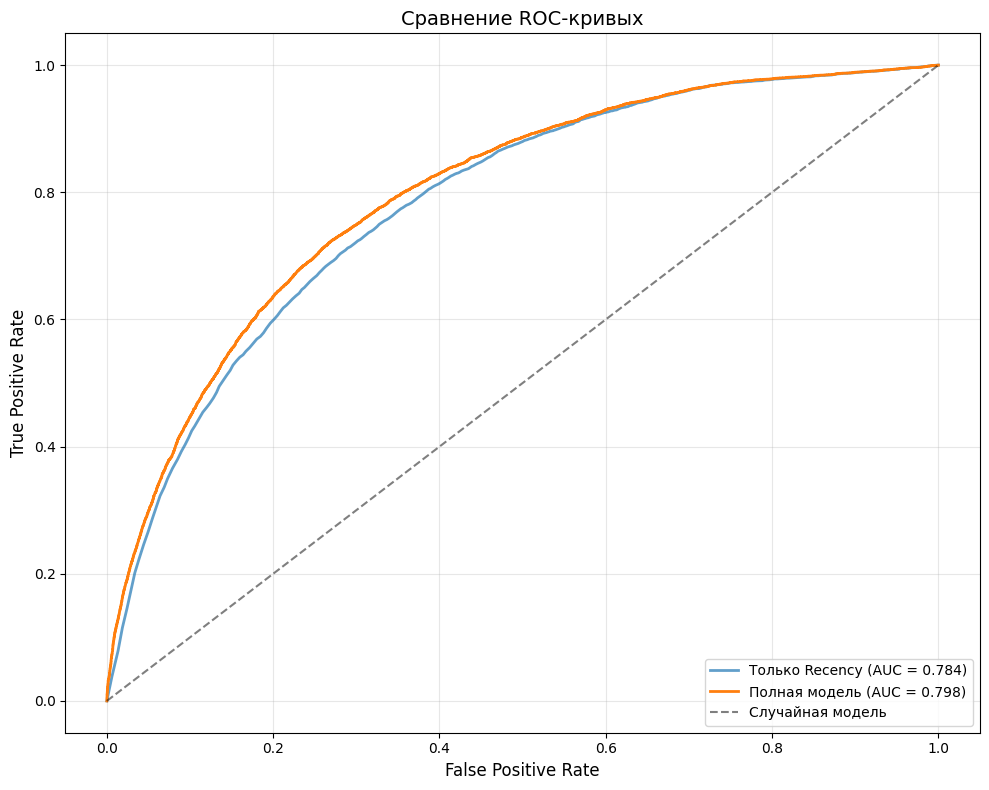

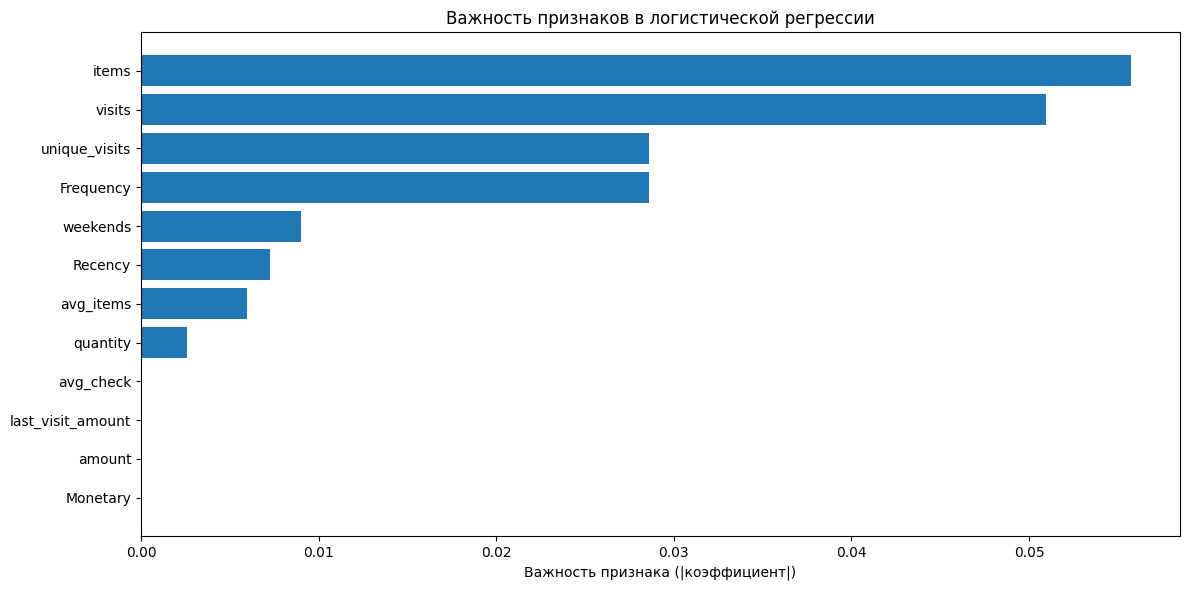

In [38]:
print("\n" + "=" * 70)
print("ЭТАП 3: ПОЛНАЯ ЛОГРЕГРЕССИЯ (L2 РЕГУЛЯРИЗАЦИЯ)")
print("=" * 70)

# 1. Создаем модель с L2 регуляризацией
model_full = LogisticRegression(
    penalty='l2',          # L2 регуляризация
    C=1.0,                 # Обратная сила регуляризации (меньше = сильнее)
    max_iter=1000,         # Больше итераций для сходимости
    random_state=42,
    solver='lbfgs'         # Хороший солвер для L2
)

# 2. Обучаем на всех признаках
model_full.fit(X_train_models, y_train_models)

# 3. Предсказания
y_pred_prob_full = model_full.predict_proba(X_test_models)[:, 1]
y_pred_full = model_full.predict(X_test_models)

# 4. Оценка модели
roc_auc_full = roc_auc_score(y_test_models, y_pred_prob_full)
print(f"ROC-AUC (полная модель): {roc_auc_full:.4f}")

# 5. Сравнение с моделью только на Recency
improvement = ((roc_auc_full - roc_auc_recency) / roc_auc_recency) * 100
print(f"\nУлучшение по сравнению с Recency: {improvement:+.1f}%")

# 6. Выводим важность признаков
print("\nВАЖНОСТЬ ПРИЗНАКОВ (абсолютные значения коэффициентов):")
feature_importance = pd.DataFrame({
    'Признак': X_train_models.columns,
    'Коэффициент': abs(model_full.coef_[0])
})
feature_importance = feature_importance.sort_values('Коэффициент', ascending=False)
print(feature_importance.to_string(index=False))

# 7. ROC-кривые сравнения
fpr_full, tpr_full, _ = roc_curve(y_test_models, y_pred_prob_full)

plt.figure(figsize=(10, 8))
plt.plot(fpr_recency, tpr_recency, label=f'Только Recency (AUC = {roc_auc_recency:.3f})', linewidth=2, alpha=0.7)
plt.plot(fpr_full, tpr_full, label=f'Полная модель (AUC = {roc_auc_full:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель', alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Сравнение ROC-кривых', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. Визуализация важности признаков
plt.figure(figsize=(12, 6))
bars = plt.barh(feature_importance['Признак'][::-1], feature_importance['Коэффициент'][::-1])
plt.xlabel('Важность признака (|коэффициент|)')
plt.title('Важность признаков в логистической регрессии')
plt.tight_layout()
plt.show()


ЭТАП 4: МОДЕЛЬ XGBOOST


C:\Users\Ksenia\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:199: UserWarning: [19:46:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC-AUC (XGBoost): 0.8090

СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:
             Модель  ROC-AUC
     Только Recency 0.784165
Полная логрегрессия 0.798121
            XGBoost 0.808975

ВАЖНОСТЬ ПРИЗНАКОВ В XGBOOST:
          Признак  Важность
          Recency  0.502460
    unique_visits  0.357195
         quantity  0.031046
        avg_items  0.019580
           visits  0.016173
        avg_check  0.016066
           amount  0.015385
            items  0.014232
         weekends  0.014149
last_visit_amount  0.013713
        Frequency  0.000000
         Monetary  0.000000


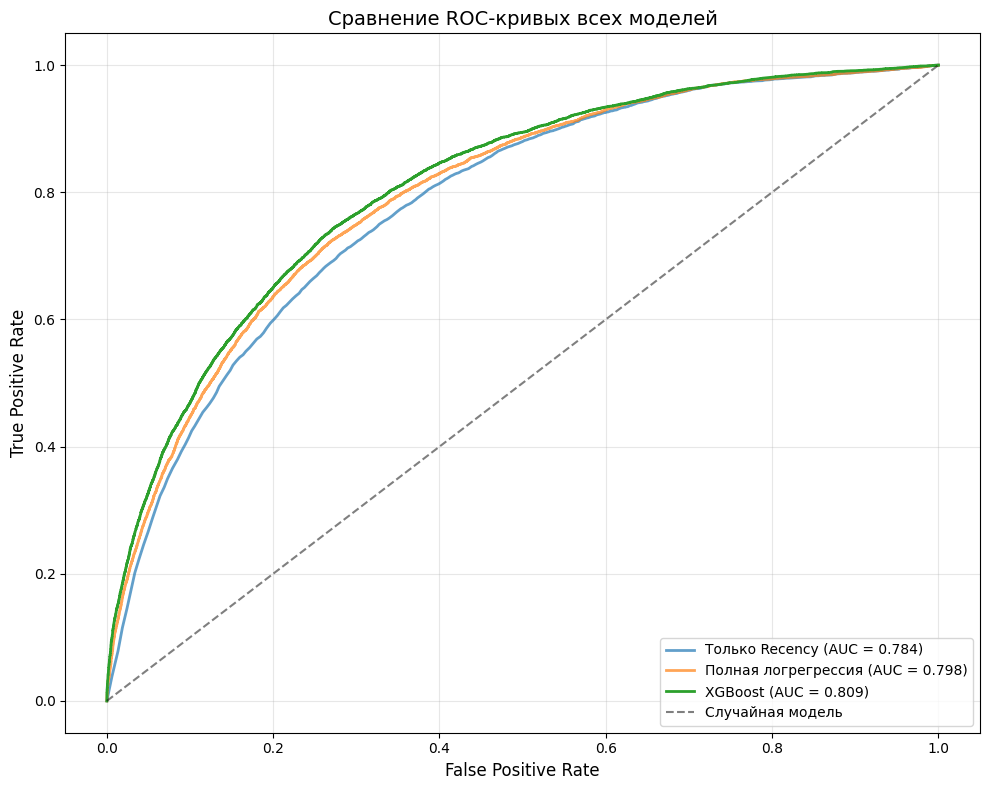

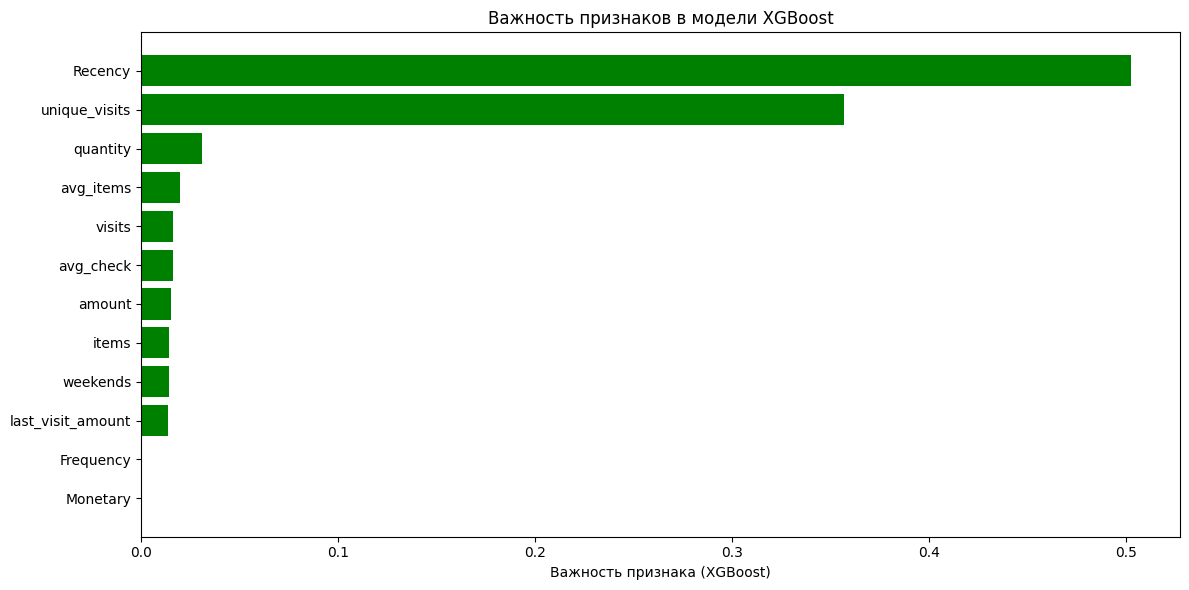

In [39]:
print("\n" + "=" * 70)
print("ЭТАП 4: МОДЕЛЬ XGBOOST")
print("=" * 70)

from xgboost import XGBClassifier

# 1. Создаем модель XGBoost с базовыми параметрами
xgb_model = XGBClassifier(
    n_estimators=100,      # Количество деревьев
    max_depth=3,           # Максимальная глубина деревьев
    learning_rate=0.1,     # Скорость обучения
    random_state=42,
    eval_metric='logloss', # Метрика для бинарной классификации
    use_label_encoder=False
)

# 2. Обучаем модель
xgb_model.fit(X_train_models, y_train_models)

# 3. Предсказания
y_pred_prob_xgb = xgb_model.predict_proba(X_test_models)[:, 1]
y_pred_xgb = xgb_model.predict(X_test_models)

# 4. Оценка модели
roc_auc_xgb = roc_auc_score(y_test_models, y_pred_prob_xgb)
print(f"ROC-AUC (XGBoost): {roc_auc_xgb:.4f}")

# 5. Сравнение со всеми моделями
print("\nСРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:")
models_comparison = pd.DataFrame({
    'Модель': ['Только Recency', 'Полная логрегрессия', 'XGBoost'],
    'ROC-AUC': [roc_auc_recency, roc_auc_full, roc_auc_xgb]
})
print(models_comparison.to_string(index=False))

# 6. Важность признаков в XGBoost
print("\nВАЖНОСТЬ ПРИЗНАКОВ В XGBOOST:")
xgb_importance = pd.DataFrame({
    'Признак': X_train_models.columns,
    'Важность': xgb_model.feature_importances_
})
xgb_importance = xgb_importance.sort_values('Важность', ascending=False)
print(xgb_importance.to_string(index=False))

# 7. ROC-кривые всех моделей
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_models, y_pred_prob_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_recency, tpr_recency, label=f'Только Recency (AUC = {roc_auc_recency:.3f})', linewidth=2, alpha=0.7)
plt.plot(fpr_full, tpr_full, label=f'Полная логрегрессия (AUC = {roc_auc_full:.3f})', linewidth=2, alpha=0.7)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель', alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Сравнение ROC-кривых всех моделей', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. Визуализация важности признаков XGBoost
plt.figure(figsize=(12, 6))
bars = plt.barh(xgb_importance['Признак'][::-1], xgb_importance['Важность'][::-1], color='green')
plt.xlabel('Важность признака (XGBoost)')
plt.title('Важность признаков в модели XGBoost')
plt.tight_layout()
plt.show()


ЭТАП 5: ВЫВОДЫ И ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ


C:\Users\Ksenia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



СРАВНЕНИЕ ВСЕХ МЕТРИК:
             Модель  ROC-AUC  Accuracy  Precision   Recall  F1-Score
            Recency 0.784165  0.811292   0.000000 0.000000  0.000000
Полная логрегрессия 0.798121  0.827653   0.644635 0.193208  0.297308
            XGBoost 0.808975  0.833964   0.636231 0.280551  0.389395

📊 ЛУЧШАЯ МОДЕЛЬ: XGBoost
   ROC-AUC: 0.8090
   F1-Score: 0.3894

💾 Сохранение лучшей модели...
Лучшая модель сохранена в 'best_model.pkl'


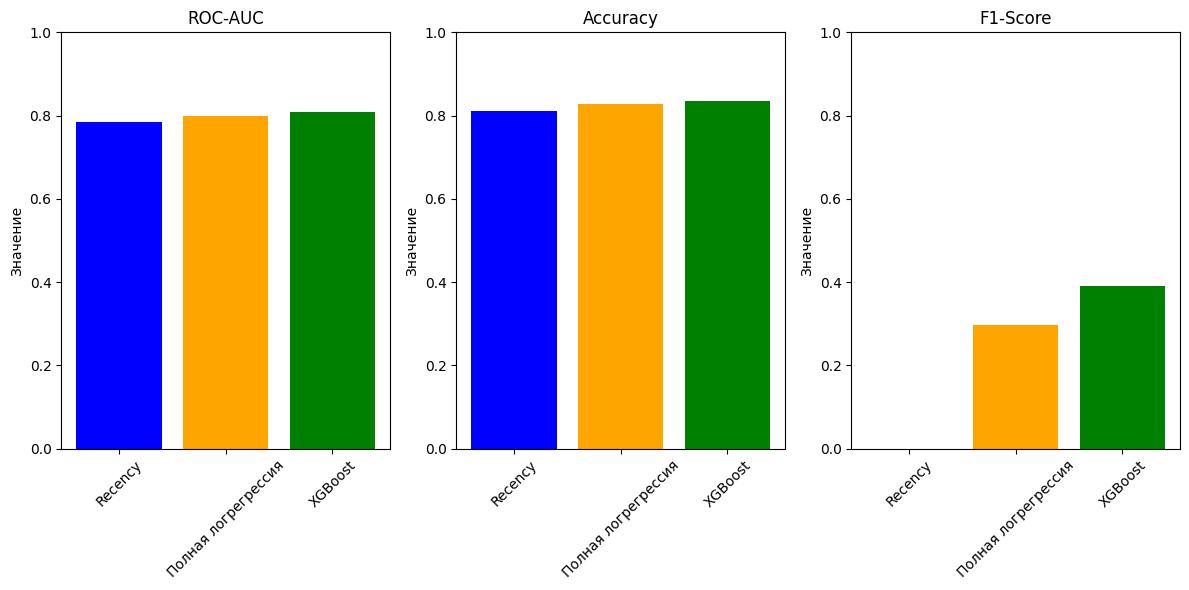


✅ ВСЕ ЭТАПЫ ЗАВЕРШЕНЫ!


In [40]:
print("\n" + "=" * 70)
print("ЭТАП 5: ВЫВОДЫ И ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ")
print("=" * 70)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Сравниваем все метрики
results = []
for model_name, y_pred, y_pred_prob in [
    ('Recency', y_pred_recency, y_pred_prob_recency),
    ('Полная логрегрессия', y_pred_full, y_pred_prob_full),
    ('XGBoost', y_pred_xgb, y_pred_prob_xgb)
]:
    results.append({
        'Модель': model_name,
        'ROC-AUC': roc_auc_score(y_test_models, y_pred_prob),
        'Accuracy': accuracy_score(y_test_models, y_pred),
        'Precision': precision_score(y_test_models, y_pred),
        'Recall': recall_score(y_test_models, y_pred),
        'F1-Score': f1_score(y_test_models, y_pred)
    })

results_df = pd.DataFrame(results)
print("\nСРАВНЕНИЕ ВСЕХ МЕТРИК:")
print(results_df.to_string(index=False))

# 2. Лучшая модель по ROC-AUC
best_model_idx = results_df['ROC-AUC'].idxmax()
best_model = results_df.loc[best_model_idx]
print(f"\n📊 ЛУЧШАЯ МОДЕЛЬ: {best_model['Модель']}")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")

# 3. Сохраняем лучшую модель
print("\n💾 Сохранение лучшей модели...")
if best_model['Модель'] == 'Recency':
    best_model_obj = model_recency
elif best_model['Модель'] == 'Полная логрегрессия':
    best_model_obj = model_full
else:
    best_model_obj = xgb_model

with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model_obj, f)
print("Лучшая модель сохранена в 'best_model.pkl'")

# 4. Графическое сравнение метрик
metrics_to_plot = ['ROC-AUC', 'Accuracy', 'F1-Score']
plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(1, 3, i)
    plt.bar(results_df['Модель'], results_df[metric], color=['blue', 'orange', 'green'])
    plt.title(metric)
    plt.ylabel('Значение')
    plt.xticks(rotation=45)
    plt.ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ ВСЕ ЭТАПЫ ЗАВЕРШЕНЫ!")
print("=" * 70)


ФИНАЛЬНЫЙ ЭТАП: ПРОГНОЗ НА СЛЕДУЮЩИЙ МЕСЯЦ
Дата построения профиля: 2019-10-01
Прогнозный период: с 2019-11-01 по 2019-12-01

🔧 Построение профиля клиентов...
Количество клиентов в профиле: 41196

🔧 Подготовка данных для прогноза...
Признаков для прогноза: 12
Клиентов для прогноза: 41196

🔧 Загрузка лучшей модели...
✅ Лучшая модель успешно загружена
Тип загруженной модели: XGBClassifier

🔮 Выполнение прогноза...

📊 Формирование итогового датасета...

📈 СТАТИСТИКА ПРОГНОЗА:
Всего клиентов: 41196
Средняя вероятность возврата: 0.1155
Медианная вероятность возврата: 0.0823
Стандартное отклонение: 0.0921

Прогнозируемые классы:
  Не вернутся (0): 41196 клиентов (100.0%)

🏆 ТОП-20 КЛИЕНТОВ С НАИБОЛЬШЕЙ ВЕРОЯТНОСТЬЮ ВОЗВРАТА:
 1. Клиент client41126 | Вероятность: 0.4787 | Recency: 3 | Frequency: 54 | Monetary: 276436.00
 2. Клиент client28721 | Вероятность: 0.4740 | Recency: 3 | Frequency: 61 | Monetary: 97931.00
 3. Клиент client11168 | Вероятность: 0.4740 | Recency: 3 | Frequency: 98 | Mon

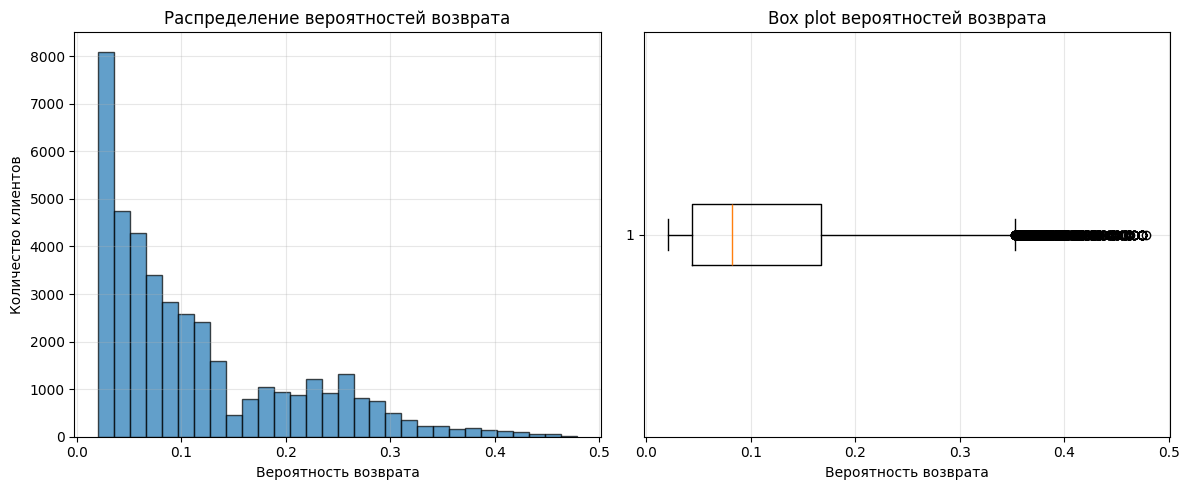


💾 Сохранение прогноза в файл...
✅ Прогноз сохранен в 'results/forecast.csv'

🔍 Проверка сохраненного файла...
Файл успешно прочитан:
  - Строк: 41196
  - Колонок: 8
  - Колонки: ['client', 'probability_return', 'predicted_class', 'Recency', 'Frequency', 'Monetary', 'total_quantity', 'unique_items']

Первые 5 строк сохраненного файла:
     client  probability_return  predicted_class  Recency  Frequency  Monetary  total_quantity  unique_items
client41126            0.478670                0        3         54    276436            1025           126
client28721            0.473981                0        3         61     97931             511           156
client11168            0.473981                0        3         98     71258             401           145
client26714            0.473981                0        3         30     77837             381           124
client16905            0.473981                0        3         64    100654             554           129

📄 Создан

In [41]:
print("\n" + "=" * 70)
print("ФИНАЛЬНЫЙ ЭТАП: ПРОГНОЗ НА СЛЕДУЮЩИЙ МЕСЯЦ")
print("=" * 70)

# 1. Определяем дату для прогноза (следующий месяц после последних данных)
# Из вашего кода видно, что последний профиль был построен на '2019-10-01'
# Прогноз будем делать на ноябрь 2019 (2019-11-01)

observation_date_for_forecast = '2019-10-01'  # Дата на которую строим профиль
forecast_start_date = '2019-11-01'            # Начало прогнозного периода
forecast_end_date = '2019-12-01'              # Конец прогнозного периода (месяц)

print(f"Дата построения профиля: {observation_date_for_forecast}")
print(f"Прогнозный период: с {forecast_start_date} по {forecast_end_date}")

# 2. Строим профиль клиентов на observation_date_for_forecast
print("\n🔧 Построение профиля клиентов...")
forecast_profile = calculate_client_profile_at_date(
    daily_summary,
    observation_end_date=observation_date_for_forecast
)

print(f"Количество клиентов в профиле: {len(forecast_profile)}")

# 3. Подготавливаем данные для прогноза
print("\n🔧 Подготовка данных для прогноза...")

# Копируем и подготавливаем данные так же, как при обучении
X_forecast = forecast_profile.drop(columns=['client', 'last_visit', 'visits', 'unique_visits', 
                                            'weekends', 'last_visit_amount', 'avg_check', 'avg_items'], 
                                  errors='ignore')

# Оставляем только числовые признаки
X_forecast_numeric = X_forecast.select_dtypes(include=[np.number])

# Синхронизируем колонки с обучающими данными
X_forecast_aligned = X_forecast_numeric.reindex(columns=X_train_models.columns, fill_value=0)

print(f"Признаков для прогноза: {X_forecast_aligned.shape[1]}")
print(f"Клиентов для прогноза: {X_forecast_aligned.shape[0]}")

# 4. Загружаем лучшую модель
print("\n🔧 Загрузка лучшей модели...")
try:
    with open("best_model.pkl", "rb") as f:
        best_model_loaded = pickle.load(f)
    print("✅ Лучшая модель успешно загружена")
    
    # Определяем какая модель была загружена
    model_type = type(best_model_loaded).__name__
    print(f"Тип загруженной модели: {model_type}")
    
except FileNotFoundError:
    print("⚠️  Лучшая модель не найдена, используем XGBoost как резерв")
    best_model_loaded = xgb_model

# 5. Делаем прогноз
print("\n🔮 Выполнение прогноза...")

# Прогнозируем вероятности
forecast_probabilities = best_model_loaded.predict_proba(X_forecast_aligned)

# Для бинарной классификации берем вероятность положительного класса (вернется)
if forecast_probabilities.shape[1] == 2:
    return_probabilities = forecast_probabilities[:, 1]
else:
    return_probabilities = forecast_probabilities

# Прогнозируем классы (для справки)
forecast_classes = best_model_loaded.predict(X_forecast_aligned)

# 6. Создаем датасет с прогнозами
print("\n📊 Формирование итогового датасета...")

forecast_results = pd.DataFrame({
    'client': forecast_profile['client'],
    'probability_return': return_probabilities,
    'predicted_class': forecast_classes,
    'Recency': X_forecast_aligned['Recency'] if 'Recency' in X_forecast_aligned.columns else 0,
    'Frequency': X_forecast_aligned['Frequency'] if 'Frequency' in X_forecast_aligned.columns else 0,
    'Monetary': X_forecast_aligned['Monetary'] if 'Monetary' in X_forecast_aligned.columns else 0
})

# Добавляем дополнительные признаки из профиля (если они есть)
if 'quantity' in forecast_profile.columns:
    forecast_results['total_quantity'] = forecast_profile['quantity']
if 'items' in forecast_profile.columns:
    forecast_results['unique_items'] = forecast_profile['items']

# 7. Сортируем по убыванию вероятности возврата
forecast_results_sorted = forecast_results.sort_values('probability_return', ascending=False).reset_index(drop=True)

# 8. Выводим статистику прогноза
print(f"\n📈 СТАТИСТИКА ПРОГНОЗА:")
print(f"Всего клиентов: {len(forecast_results_sorted)}")
print(f"Средняя вероятность возврата: {forecast_results_sorted['probability_return'].mean():.4f}")
print(f"Медианная вероятность возврата: {forecast_results_sorted['probability_return'].median():.4f}")
print(f"Стандартное отклонение: {forecast_results_sorted['probability_return'].std():.4f}")

# Статистика по прогнозируемым классам
if 'predicted_class' in forecast_results_sorted.columns:
    class_counts = forecast_results_sorted['predicted_class'].value_counts()
    print(f"\nПрогнозируемые классы:")
    if 1 in class_counts.index:
        print(f"  Вернутся (1): {class_counts[1]} клиентов ({class_counts[1]/len(forecast_results_sorted)*100:.1f}%)")
    if 0 in class_counts.index:
        print(f"  Не вернутся (0): {class_counts[0]} клиентов ({class_counts[0]/len(forecast_results_sorted)*100:.1f}%)")

# 9. Показываем топ-20 клиентов с наибольшей вероятностью возврата
print(f"\n🏆 ТОП-20 КЛИЕНТОВ С НАИБОЛЬШЕЙ ВЕРОЯТНОСТЬЮ ВОЗВРАТА:")
print("=" * 90)
top_20 = forecast_results_sorted.head(20)
for i, row in top_20.iterrows():
    print(f"{i+1:2}. Клиент {row['client']:10} | "
          f"Вероятность: {row['probability_return']:.4f} | "
          f"Recency: {row['Recency']:.0f} | "
          f"Frequency: {row['Frequency']:.0f} | "
          f"Monetary: {row['Monetary']:.2f}")

# 10. Показываем распределение вероятностей
print(f"\n📊 РАСПРЕДЕЛЕНИЕ ВЕРОЯТНОСТЕЙ:")
probability_bins = pd.cut(forecast_results_sorted['probability_return'], 
                          bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                          labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
bin_counts = probability_bins.value_counts().sort_index()
for bin_label, count in bin_counts.items():
    percentage = count / len(forecast_results_sorted) * 100
    print(f"  {bin_label}: {count:4} клиентов ({percentage:.1f}%)")

# 11. Визуализация распределения вероятностей
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(forecast_results_sorted['probability_return'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Вероятность возврата')
plt.ylabel('Количество клиентов')
plt.title('Распределение вероятностей возврата')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Box plot вероятностей
plt.boxplot(forecast_results_sorted['probability_return'], vert=False)
plt.xlabel('Вероятность возврата')
plt.title('Box plot вероятностей возврата')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 12. Сохраняем прогноз в файл
print("\n💾 Сохранение прогноза в файл...")
forecast_results_sorted.to_csv('results/forecast.csv', index=False, encoding='utf-8-sig')
print("✅ Прогноз сохранен в 'results/forecast.csv'")

# 13. Проверяем сохраненный файл
print("\n🔍 Проверка сохраненного файла...")
try:
    saved_forecast = pd.read_csv('results/forecast.csv', encoding='utf-8-sig')
    print(f"Файл успешно прочитан:")
    print(f"  - Строк: {saved_forecast.shape[0]}")
    print(f"  - Колонок: {saved_forecast.shape[1]}")
    print(f"  - Колонки: {saved_forecast.columns.tolist()}")
    
    print(f"\nПервые 5 строк сохраненного файла:")
    print(saved_forecast.head().to_string(index=False))
    
except Exception as e:
    print(f"Ошибка при чтении файла: {e}")

# 14. Дополнительно: сохраняем сводный отчет
print("\n📄 Создание сводного отчета...")

summary_report = {
    'Дата создания': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'Дата построения профиля': observation_date_for_forecast,
    'Прогнозный период': f'{forecast_start_date} - {forecast_end_date}',
    'Всего клиентов': len(forecast_results_sorted),
    'Использованная модель': model_type,
    'Средняя вероятность': forecast_results_sorted['probability_return'].mean(),
    'Медианная вероятность': forecast_results_sorted['probability_return'].median(),
    'Минимальная вероятность': forecast_results_sorted['probability_return'].min(),
    'Максимальная вероятность': forecast_results_sorted['probability_return'].max(),
    'Прогнозируется возврат': class_counts.get(1, 0) if 'predicted_class' in forecast_results_sorted.columns else 'N/A'
}

summary_df = pd.DataFrame([summary_report])
summary_df.to_csv('results/forecast_summary.csv', index=False, encoding='utf-8-sig')
print("✅ Сводный отчет сохранен в 'results/forecast_summary.csv'")

print("\n" + "=" * 70)
print("🎉 ФИНАЛЬНЫЙ ПРОГНОЗ УСПЕШНО ЗАВЕРШЕН!")
print("=" * 70)
print(f"\nИтоговый файл прогноза: results/forecast.csv")
print(f"Всего прогнозируемых клиентов: {len(forecast_results_sorted)}")
print(f"Диапазон вероятностей: от {forecast_results_sorted['probability_return'].min():.4f} "
      f"до {forecast_results_sorted['probability_return'].max():.4f}")